In [1]:
from pymongo import MongoClient
from matplotlib import pyplot as plt
import numpy as np
from dcase2020_task2.data_sets.mcm_dataset import INVERSE_CLASS_MAP, TRAINING_ID_MAP, EVALUATION_ID_MAP, CLASS_MAP
from scipy.stats import rankdata
import os
from shutil import copyfile
import pandas as pd

baseline_auc = {
    'name': 'baseline',
    0: {0: 0.5441, 2: 0.7340, 4: 0.6161, 6: 0.7392},
    1: {0: 0.6715, 2: 0.6153, 4: 0.8833, 6: 0.7455},
    2: {0: 0.9619, 2: 0.7897, 4: 0.9430, 6: 0.6959},
    3: {1: 0.8136, 2: 0.8597, 3: 0.6330, 4: 0.8445},
    4: {1: 0.7807, 2: 0.6416, 3: 0.7535},
    5: {0: 0.6876, 2: 0.6818, 4: 0.7430, 6: 0.5390}
    }
    
baseline_pauc = {
    'name': 'baseline',
    0: {0: 0.4937, 2: 0.5481, 4: 0.5326, 6: 0.5235},
    1: {0: 0.5674, 2: 0.5810, 4: 0.6710, 6: 0.5802},
    2: {0: 0.8144, 2: 0.6368, 4: 0.7198, 6: 0.4902},
    3: {1: 0.6840, 2: 0.7772, 3: 0.5521, 4: 0.6897},
    4: {1: 0.6425, 2: 0.5601, 3: 0.6103},
    5: {0: 0.5170, 2: 0.5183, 4: 0.5197, 6: 0.4843}
}

baseline_both = {}
for t in baseline_auc:
    if t == 'name':
        baseline_both[t] = 'baseline'
        continue
    else:
        baseline_both[t] = {}
    for i in baseline_auc[t]:
        baseline_both[t][i] = np.array([baseline_auc[t][i], baseline_pauc[t][i]])


def get_experiment(runs, name):
    experiment_dict = dict()
    for i in range(6):
        experiment_dict[i] = dict()
    
    experiment_dict['name'] = name
    
    for experiment in runs:
        if experiment['config'].get('id') == name:
            machine_dict = experiment_dict.get(experiment['config']['machine_type'])
            result = experiment.get('result')
            machine_type = INVERSE_CLASS_MAP[experiment['config']['machine_type']]
            machine_id = experiment['config']['machine_id']
            
            if result:
                machine_dict[experiment['config']['machine_id']] = result.get(
                    machine_type, {}
                ).get(
                    f'json://{machine_id}', -1
                ).get('py/tuple', [0, 0])[:2]
            else:
                machine_dict[experiment['config']['machine_id']] = np.array([0, 0])
    return experiment_dict


def get_record(experiment):
    record = []
    for i in range(6):
        for j in TRAINING_ID_MAP[i]:
                v = experiment.get(i)
                if v:
                    v = v.get(j, [0, 0])
                else:
                    v = np.array([0, 0])
                record.append(np.array(v))
    assert len(record) == 23
    return  experiment['name'], record

In [2]:
client = MongoClient('mongodb://student2.cp.jku.at:27017/')
experiments = [r for r in client.resnet_gridsearch.runs.find({"experiment.name": "dcase2020_task2_ClassificationExperiment"})]
print(f'Loaded {len(experiments)} runs.')

Loaded 572 runs.


In [3]:
descriptors = set()
for experiment in experiments:
    descriptors = descriptors.union(set([experiment['config']['id']]))
descriptors = list(descriptors)
print(f'Loaded {len(descriptors)} distinct experiments.')

Loaded 25 distinct experiments.


In [4]:
descriptors = [d for d in descriptors if d.split('_')[-1] != 'rerun']
# descriptors = [d for d in descriptors if d.split('_')[2] != '2']
# for descriptor in descriptors:
#     print(descriptor)
    
print(f'Loaded {len(descriptors)} distinct experiments, without reruns.')

Loaded 13 distinct experiments, without reruns.


In [5]:
# Extract Results
# Concatenate Baseline Results
n, m = get_record(baseline_both)
names = [n]
metrics = [np.array(m)]

for descriptor in descriptors:
    n, m = get_record(
            get_experiment(
                experiments, 
                descriptor
            )
        )
    names.append(n)
    metrics.append(np.array(m))

In [ ]:
import sklearn

def compute_auc(src):
    scores = pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 1]
    names = pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 0]
    names = np.array([1 if name.split('_')[0] == 'anomaly' else 0 for name in names])
    return sklearn.metrics.roc_auc_score(names, scores), sklearn.metrics.roc_auc_score(names, scores, max_fpr=0.1)

In [23]:
data = np.array(metrics)
auc_ranks = []
pauc_ranks = []
idxes = [0, 4, 8, 12, 16, 19, 23]
best_idxes = []
for type_, (i, j) in enumerate(zip(idxes[:-1], idxes[1:])):
    average_auc = data[:, i:j, 0].mean(axis=1)
    average_pauc = data[:, i:j, 1].mean(axis=1)
    best_idxes.append(
       np.argsort(average_auc + average_pauc)[::-1]
    )
    print(f'Best Model for Machine Type {type_}: {best_idxes[-1]}')
    auc_ranks.append(rankdata(-average_auc))
    pauc_ranks.append(rankdata(-average_pauc))


ranks = np.stack([np.array(list(zip(*auc_ranks))), np.array(list(zip(*pauc_ranks)))], axis=-1).mean(axis=-1).mean(axis=-1)

sorted_model_indices = list(np.argsort(ranks))
names = np.array(names)

Best Model for Machine Type 0: [ 8  9 11  6  5  3  7 12 10  1 13  4  2  0]
Best Model for Machine Type 1: [ 8 12  9  3 10 11 13  7  5  6  1  2  4  0]
Best Model for Machine Type 2: [12 11  6  8  5 10  7 13  3  9  4  2  1  0]
Best Model for Machine Type 3: [ 7  6  4 11  5  9 12 10  8 13  3  2  1  0]
Best Model for Machine Type 4: [13 10  6  5 12  3  1  9  2  4 11  7  8  0]
Best Model for Machine Type 5: [ 8  4  2  7  1 12 11  3  9 13  5  6 10  0]


In [60]:
aucs_ = []
paucs_ = [] 
for i, (n, r, j) in enumerate(zip(names[sorted_model_indices][:-1], ranks[sorted_model_indices], sorted_model_indices)):
    aucs = []
    paucs = [] 
    for machine_type, idxes in enumerate(best_idxes):
        auc = []
        pauc = []
        for machine_id in TRAINING_ID_MAP[machine_type]:
            idx = idxes[0]
            best_model_folder = n
            src_path = os.path.join('..', 'experiment_logs', best_model_folder)
            src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
            a, p = compute_auc(src)
            auc.append(a)
            pauc.append(p)
        aucs.append(np.mean(auc))
        paucs.append(np.mean(pauc))
        
    aucs_.append(aucs)
    paucs_.append(paucs)
        # print(f'\t{INVERSE_CLASS_MAP[machine_type]}:\n\t\taveraged_auc: {np.mean(auc)}\n\t\taveraged_pauc: {np.mean(pauc)}')

bl = np.array(get_record(baseline_both)[1])
auc = []
pauc = []
idxes = [0, 4, 8, 12, 16, 19, 23]
for type_, (i, j) in enumerate(zip(idxes[:-1], idxes[1:])):
    auc.append(bl[i:j, 0].mean())
    pauc.append(bl[i:j, 1].mean())
aucs_ = [auc] + aucs_
paucs_ = [pauc] + paucs_

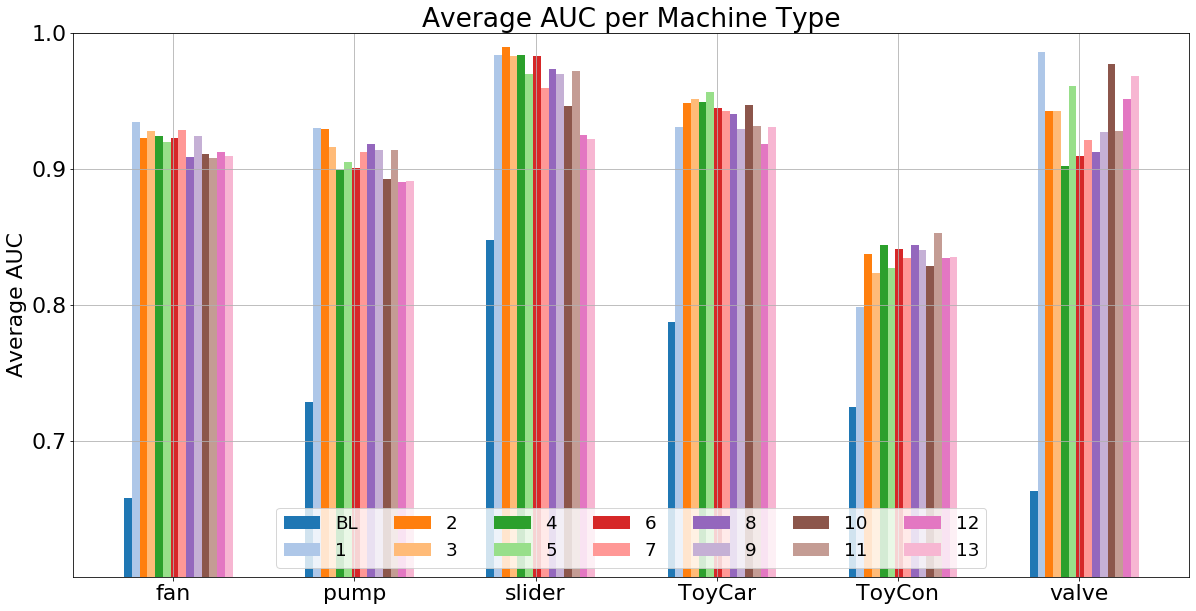

In [77]:
bar_width = 0.6
bar_spacing=0.00
top = 10
cm = plt.cm.get_cmap('tab20')

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.title(f'Average AUC per Machine Type')
labels = []

for i in range(6):
    labels.append(INVERSE_CLASS_MAP[i][:6])

for i, d in enumerate(aucs_):
    plt.bar(
        np.arange(len(labels)) + i * (bar_width / len(aucs_) + bar_spacing), 
        d,
        bar_width/ len(aucs_),
        label= 'BL' if i == 0 else i,
        color=cm.colors[i]
    )

plt.xticks(np.arange(len(labels)) + 0.25, labels)
plt.ylim(0.6, 1.)
plt.ylabel('Average AUC')
plt.yticks(np.arange(0.7, 1., 0.1))
plt.grid()
plt.legend(loc='lower center', ncol=7, fontsize='small')
plt.savefig(f'AUC.png')
plt.show()

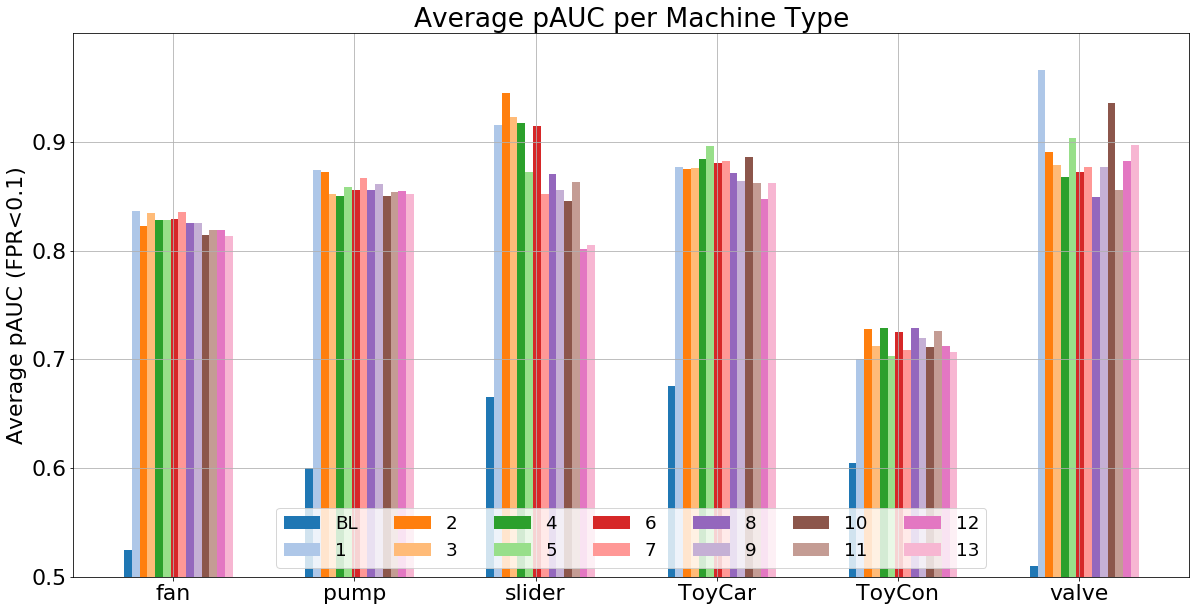

In [76]:
bar_width = 0.6
bar_spacing=0.00
top = 10
cm = plt.cm.get_cmap('tab20')

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 22})
plt.title(f'Average pAUC per Machine Type')
labels = []

for i in range(6):
    labels.append(INVERSE_CLASS_MAP[i][:6])

for i, d in enumerate(paucs_):
    plt.bar(
        np.arange(len(labels)) + i * (bar_width / len(aucs_) + bar_spacing), 
        d,
        bar_width/ len(aucs_),
        label= 'BL' if i == 0 else i,
        color=cm.colors[i]
    )

plt.xticks(np.arange(len(labels)) + 0.25, labels)
plt.ylim(0.6, 1.)
plt.ylabel('Average pAUC (FPR<0.1)')
plt.yticks(np.arange(0.5, 1., 0.1))
plt.grid()
plt.legend(loc='lower center', ncol=7, fontsize='small')
plt.savefig(f'pAUC.png')
plt.show()

In [ ]:
run_ids = names


In [8]:
# Create Submission 1

In [21]:
print(run_ids[sorted_model_indices[0]])
for machine_type in range(6):
    for machine_id in EVALUATION_ID_MAP[machine_type]:
        best_model_folder = run_ids[sorted_model_indices[0]]
        src_path = os.path.join('..', 'experiment_logs', best_model_folder)
        src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
        dst_path = os.path.join('..', 'submission_package', 'task2', 'Primus_CP-JKU_task2_1')
        dst = os.path.join(dst_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id:02d}.csv')
        copyfile(src, dst)

resnet_gridsearch_2_a_bit_larger_loose_1e-4_0.99_100_BCE


In [20]:
print(run_ids[sorted_model_indices[0]])
for machine_type in range(6):
    auc = []
    pauc = []
    for machine_id in TRAINING_ID_MAP[machine_type]:
        best_model_folder = run_ids[sorted_model_indices[0]]
        src_path = os.path.join('..', 'experiment_logs', best_model_folder)
        src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
        a, p = compute_auc(src)
        auc.append(a)
        pauc.append(p)
        
    print(f'\t{INVERSE_CLASS_MAP[machine_type]}:\n\t\taveraged_auc: {np.mean(auc)}\n\t\taveraged_pauc: {np.mean(pauc)}')

resnet_gridsearch_2_a_bit_larger_loose_1e-4_0.99_100_BCE
	fan:
		averaged_auc: 0.9344751194772806
		averaged_pauc: 0.8364269016605993
	pump:
		averaged_auc: 0.9300024538524538
		averaged_pauc: 0.8738435129147204
	slider:
		averaged_auc: 0.9836423220973782
		averaged_pauc: 0.9154346540508576
	ToyCar:
		averaged_auc: 0.931301008739688
		averaged_pauc: 0.8765960785325235
	ToyConveyor:
		averaged_auc: 0.798378625478885
		averaged_pauc: 0.7003532276454104
	valve:
		averaged_auc: 0.9858539915966387
		averaged_pauc: 0.9664464469998526


In [160]:


# Create Submission 2

In [11]:
for machine_type, idxes in enumerate(best_idxes):
    for machine_id in EVALUATION_ID_MAP[machine_type]:
        
        idx = idxes[0]
        best_model_folder = run_ids[idx]

        src_path = os.path.join('..', 'experiment_logs', best_model_folder)
        src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
        dst_path = os.path.join('..', 'submission_package', 'task2', 'Primus_CP-JKU_task2_2')
        dst = os.path.join(dst_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id:02d}.csv')
        copyfile(src, dst)
        

In [12]:
for machine_type, idxes in enumerate(best_idxes):
    auc = []
    pauc = []
    for machine_id in TRAINING_ID_MAP[machine_type]:
        idx = idxes[0]
        best_model_folder = run_ids[idx]
        src_path = os.path.join('..', 'experiment_logs', best_model_folder)
        src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
        a, p = compute_auc(src)
        auc.append(a)
        pauc.append(p)
        
    print(f'\t{INVERSE_CLASS_MAP[machine_type]}:\n\t\taveraged_auc: {np.mean(auc)}\n\t\taveraged_pauc: {np.mean(pauc)}')

	fan:
		averaged_auc: 0.9344751194772806
		averaged_pauc: 0.8364269016605993
	pump:
		averaged_auc: 0.9300024538524538
		averaged_pauc: 0.8738435129147204
	slider:
		averaged_auc: 0.9894779962546816
		averaged_pauc: 0.9454464813719693
	ToyCar:
		averaged_auc: 0.9566950093931226
		averaged_pauc: 0.8961968600747151
	ToyConveyor:
		averaged_auc: 0.8526503235962499
		averaged_pauc: 0.7259891865658302
	valve:
		averaged_auc: 0.9858539915966387
		averaged_pauc: 0.9664464469998526


In [13]:
# Create Submission 3 # median ensemble

In [14]:
for machine_type, idxes in enumerate(best_idxes):
    for machine_id in EVALUATION_ID_MAP[machine_type]:
        file_names = []
        scores = []
        for idx in idxes[:5]:
            best_model_folder = run_ids[idx]
            src_path = os.path.join('..', 'experiment_logs', best_model_folder)
            src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
            scores.append(pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 1])
            file_names.append(pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 0])
        
        scores = list(np.median(np.array(scores).T, axis=-1).reshape(-1))
        dst_path = os.path.join('..', 'submission_package', 'task2', 'Primus_CP-JKU_task2_3')
        dst = os.path.join(dst_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id:02d}.csv')

        pd.DataFrame(list(zip(file_names[0], scores))).to_csv(dst, index=False, header=False)

In [15]:

for machine_type, idxes in enumerate(best_idxes):
    auc = []
    pauc = []
    for machine_id in TRAINING_ID_MAP[machine_type]:
        file_names = []
        scores = []
        for idx in idxes[:5]:
            best_model_folder = run_ids[idx]
            src_path = os.path.join('..', 'experiment_logs', best_model_folder)
            src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
            scores.append(pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 1])
            file_names.append(pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 0])
        
        scores = list(np.median(np.array(scores).T, axis=-1).reshape(-1))
        file_names = np.array([1 if name.split('_')[0] == 'anomaly' else 0 for name in file_names[0]])      
        a, p = sklearn.metrics.roc_auc_score(file_names, scores), sklearn.metrics.roc_auc_score(file_names, scores, max_fpr=0.1)
        auc.append(a)
        pauc.append(p)
            
    print(f'\t{INVERSE_CLASS_MAP[machine_type]}:\n\t\taveraged_auc: {np.mean(auc)}\n\t\taveraged_pauc: {np.mean(pauc)}')

	fan:
		averaged_auc: 0.9281888985937587
		averaged_pauc: 0.8283523606556178
	pump:
		averaged_auc: 0.9209936334730452
		averaged_pauc: 0.8705862272890137
	slider:
		averaged_auc: 0.9858871722846442
		averaged_pauc: 0.9268061304947763
	ToyCar:
		averaged_auc: 0.9547106714040676
		averaged_pauc: 0.8913650442572985
	ToyConveyor:
		averaged_auc: 0.8514805262648587
		averaged_pauc: 0.7374989794507775
	valve:
		averaged_auc: 0.9696039915966386
		averaged_pauc: 0.9118411838419578


In [16]:
# Create Submission 4 # mean ensemble

In [17]:
for machine_type, idxes in enumerate(best_idxes):
    for machine_id in EVALUATION_ID_MAP[machine_type]:
        file_names = []
        scores = []
        for idx in idxes[:13]:
            best_model_folder = run_ids[idx]
            src_path = os.path.join('..', 'experiment_logs', best_model_folder)
            src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
            scores.append(pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 1])
            file_names.append(pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 0])
        
        scores = list(np.median(np.array(scores).T, axis=-1).reshape(-1))
        dst_path = os.path.join('..', 'submission_package', 'task2', 'Primus_CP-JKU_task2_4')
        dst = os.path.join(dst_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id:02d}.csv')

        pd.DataFrame(list(zip(file_names[0], scores))).to_csv(dst, index=False, header=False)

In [18]:

for machine_type, idxes in enumerate(best_idxes):
    auc = []
    pauc = []
    for machine_id in TRAINING_ID_MAP[machine_type]:
        file_names = []
        scores = []
        for idx in idxes[:13]:
            best_model_folder = run_ids[idx]
            src_path = os.path.join('..', 'experiment_logs', best_model_folder)
            src = os.path.join(src_path, f'anomaly_score_{INVERSE_CLASS_MAP[machine_type]}_id_{machine_id}_mean.csv')
            scores.append(pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 1])
            file_names.append(pd.read_csv(src, names=['file_name', 'score'], index_col=False).to_numpy()[:, 0])
        
        scores = list(np.median(np.array(scores).T, axis=-1).reshape(-1))
        file_names = np.array([1 if name.split('_')[0] == 'anomaly' else 0 for name in file_names[0]])      
        a, p = sklearn.metrics.roc_auc_score(file_names, scores), sklearn.metrics.roc_auc_score(file_names, scores, max_fpr=0.1)
        auc.append(a)
        pauc.append(p)
            
    print(f'\t{INVERSE_CLASS_MAP[machine_type]}:\n\t\taveraged_auc: {np.mean(auc)}\n\t\taveraged_pauc: {np.mean(pauc)}')

	fan:
		averaged_auc: 0.9230309586203593
		averaged_pauc: 0.8285210664235381
	pump:
		averaged_auc: 0.9146627457465693
		averaged_pauc: 0.8678065821022478
	slider:
		averaged_auc: 0.9822893258426966
		averaged_pauc: 0.9108762073723635
	ToyCar:
		averaged_auc: 0.9504648370497427
		averaged_pauc: 0.8890240180210388
	ToyConveyor:
		averaged_auc: 0.8254031447576784
		averaged_pauc: 0.7026976317730064
	valve:
		averaged_auc: 0.93825
		averaged_pauc: 0.8792763157894736
